- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In [32]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# big guns
import tensorflow as tf

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 16, 8

random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

Data description can be found here: https://www.kaggle.com/c/titanic/data

In [3]:
train_df = pd.read_csv("data/train.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,None,S


What columns?

In [5]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Quick & dirty exploration

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.345679,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.028212,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,148,3
top,"Boulos, Miss. Nourelain",male,347082,None,S
freq,1,577,7,687,646


Last row represents frequency of top results found in the column

Pivoting

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Visual Exploration

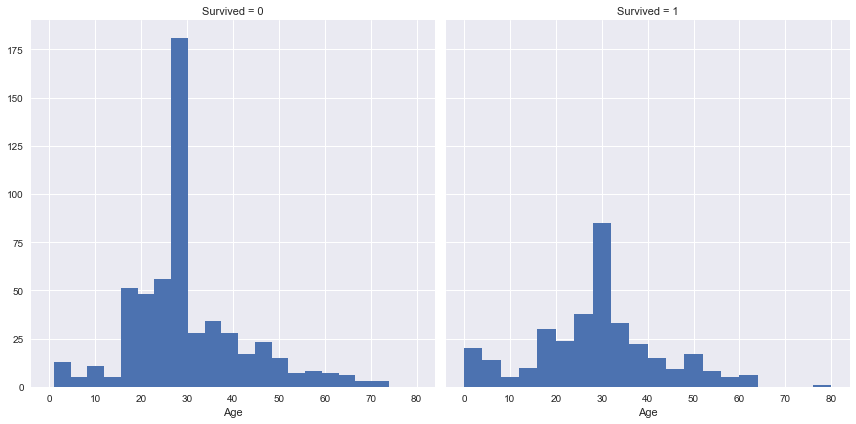

In [18]:
g = sns.FacetGrid(train_df, col='Survived', size=6)
g.map(plt.hist, 'Age', bins=20);

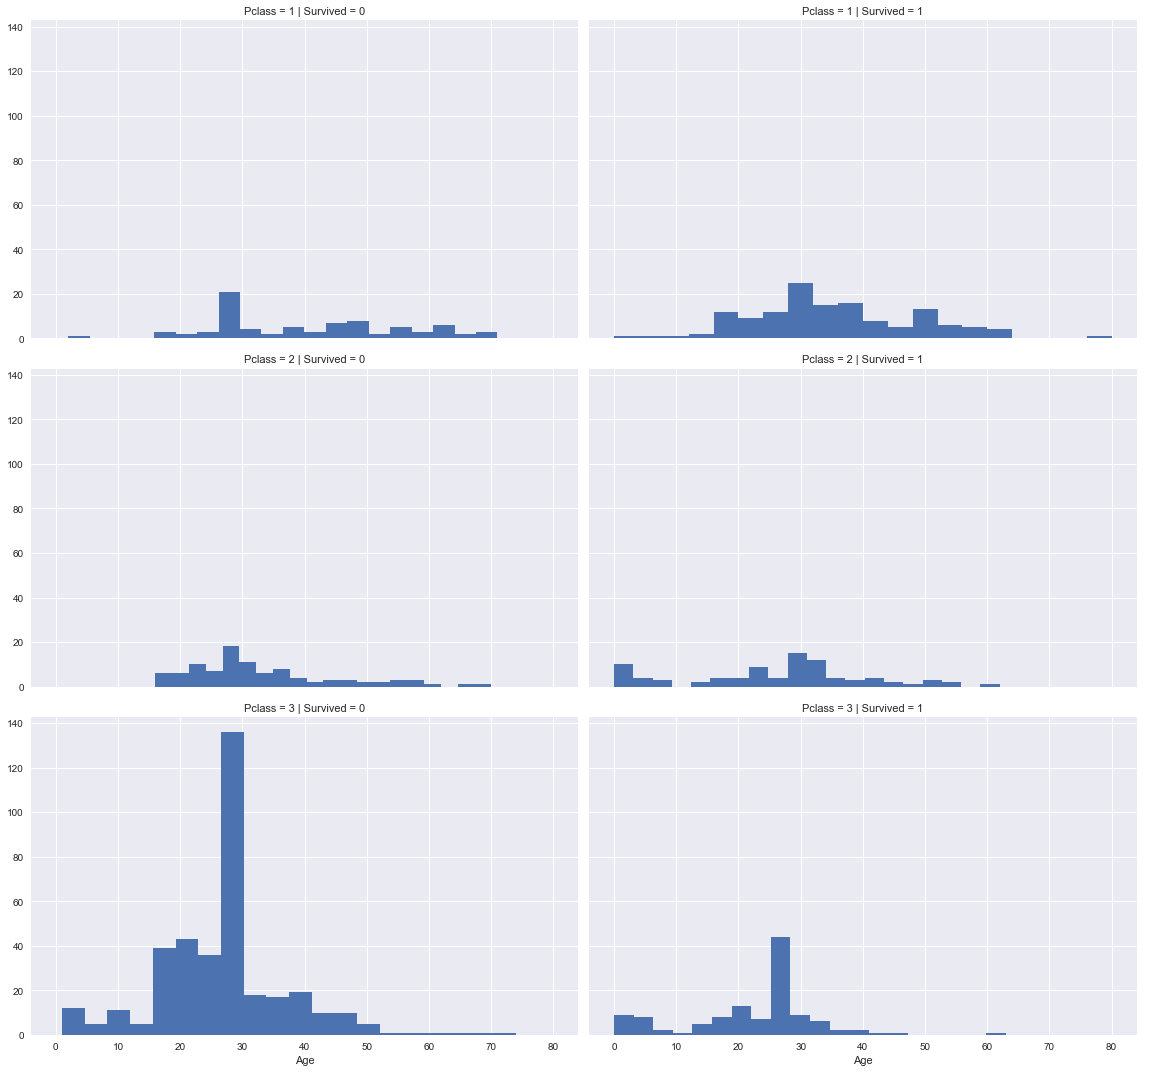

In [27]:
g = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=5, aspect=1.6)
g.map(plt.hist, 'Age', bins=20)
g.add_legend();

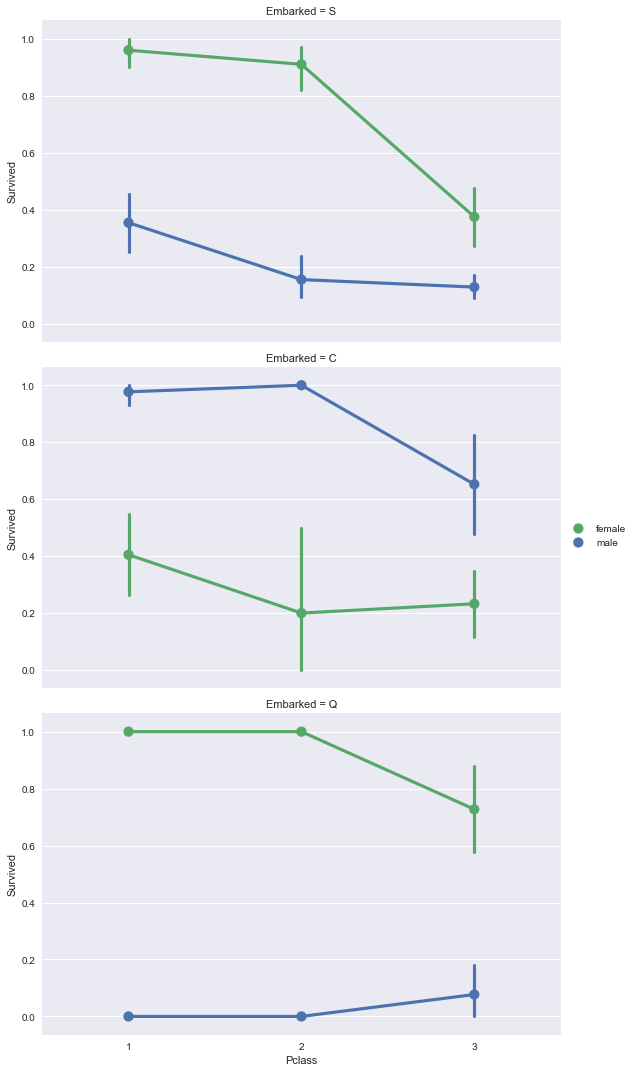

In [30]:
grid = sns.FacetGrid(train_df, row='Embarked', size=5, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend();

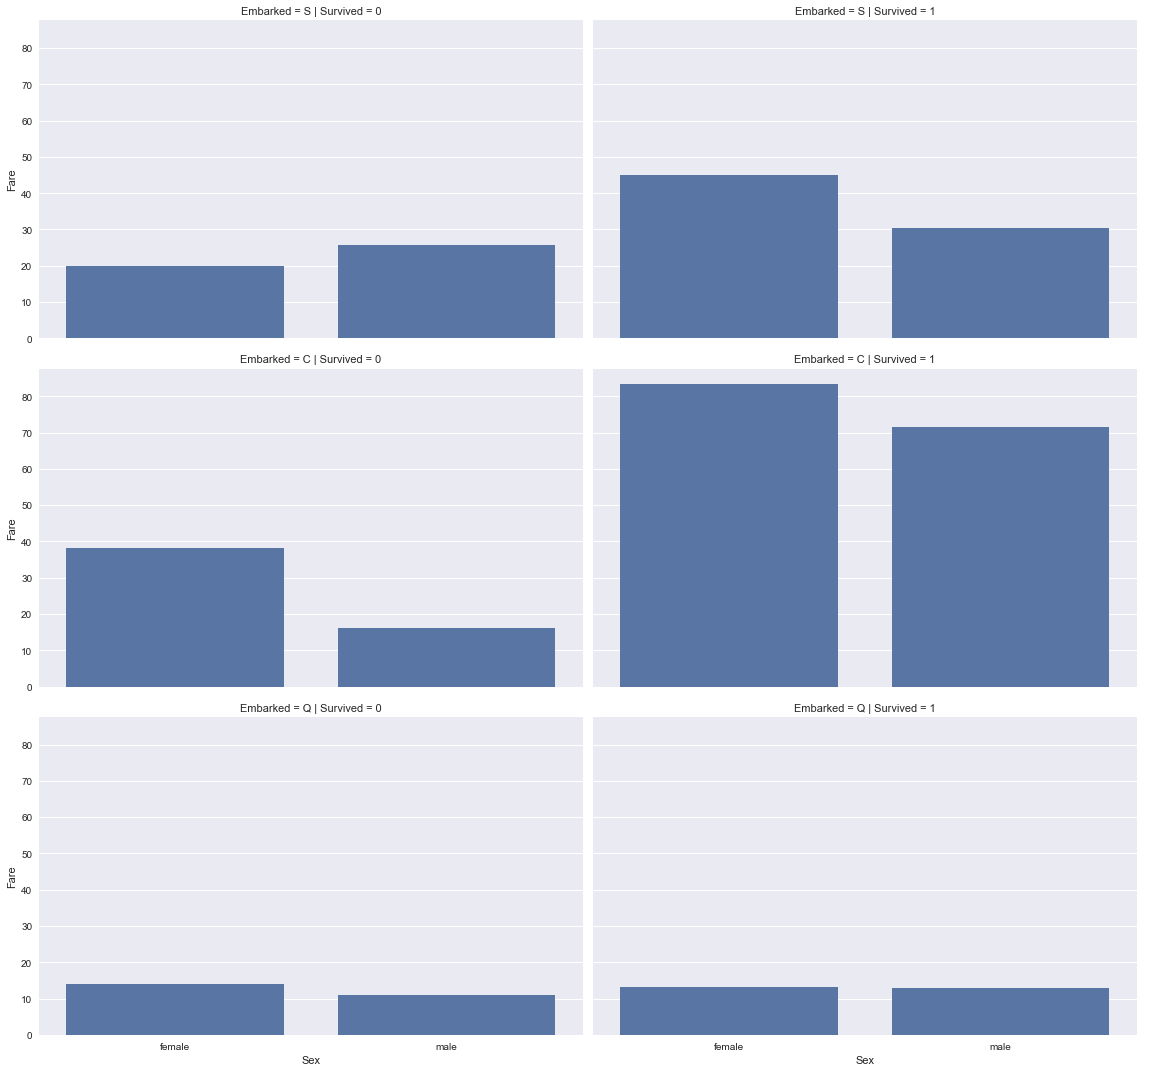

In [31]:
g = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=5, aspect=1.6)
g.map(sns.barplot, 'Sex', 'Fare', ci=None)
g.add_legend();